# Titanic Survival Prediction
Project start date: YYYY-MM-DD  
Goal: Predict survival using classic Titanic dataset. This notebook documents data exploration, preprocessing, modeling, evaluation, and conclusions.


In [17]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
print("Setup OK")


Setup OK


In [18]:
df = pd.read_csv('train.csv')
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


## 2. Exploratory Data Analysis (EDA)
Investigate distributions, correlations and missing values to guide preprocessing.


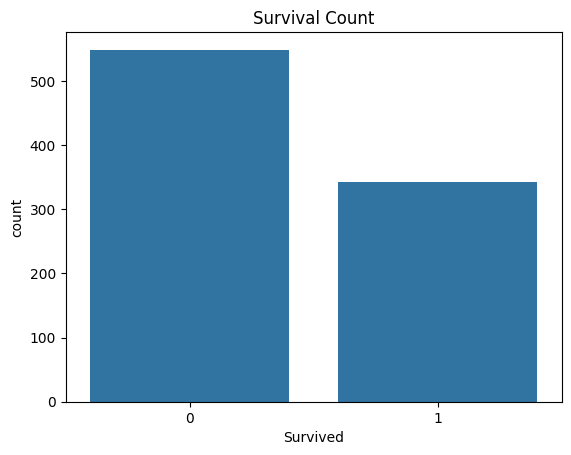

In [20]:
sns.countplot(x='Survived', data=df)
plt.title('Survival Count'); plt.show()


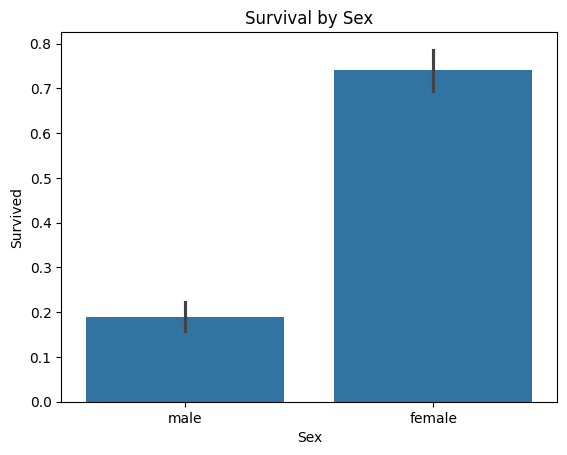

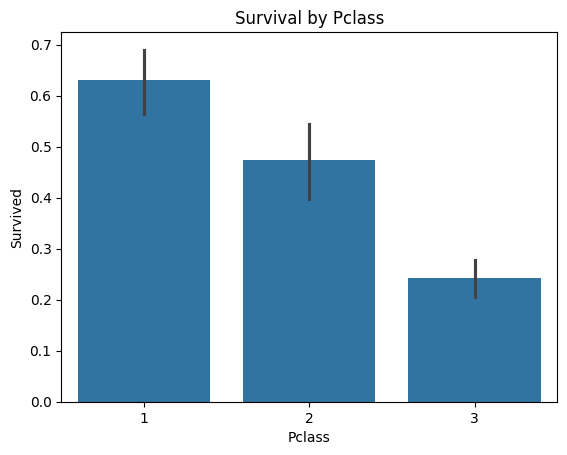

In [21]:
sns.barplot(x='Sex', y='Survived', data=df)
plt.title('Survival by Sex'); plt.show()

sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Survival by Pclass'); plt.show()


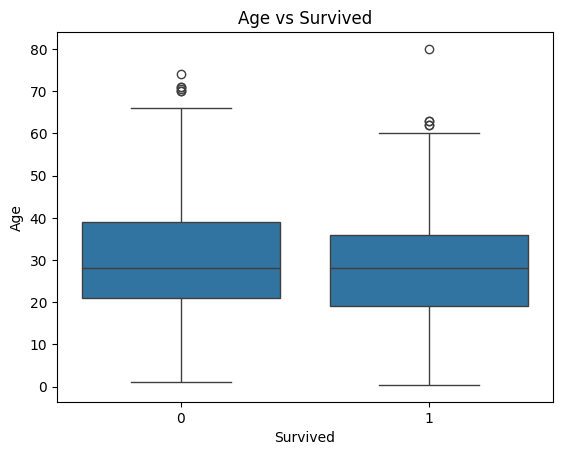

In [22]:
sns.boxplot(x='Survived', y='Age', data=df)
plt.title('Age vs Survived'); plt.show()


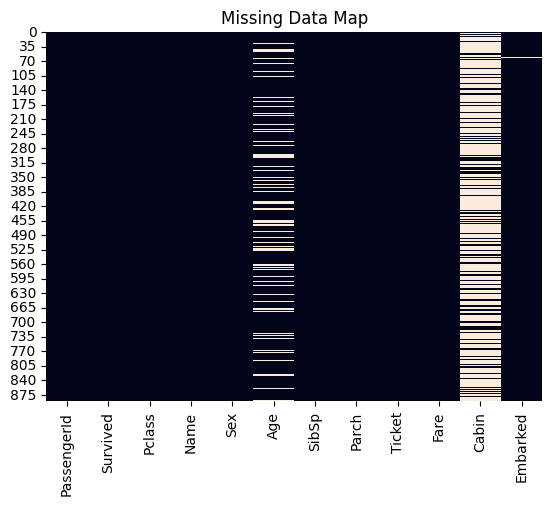

In [23]:
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing Data Map'); plt.show()


## 3. Preprocessing & Feature Engineering
Plan: fill Age with median, fill Embarked with mode, drop Cabin/Ticket/Name, create FamilySize and IsAlone, encode Sex and Embarked.


In [24]:
# Step 3: Data Preprocessing (Fixed for pandas 3.0+)
df_processed = df.copy()  # always work on a copy to avoid SettingWithCopyWarning

# Handle missing values safely (no inplace=True)
df_processed['Age'] = df_processed['Age'].fillna(df_processed['Age'].median())
df_processed['Embarked'] = df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0])

# Drop irrelevant columns
df_processed = df_processed.drop(['Cabin', 'Ticket', 'Name'], axis=1)

# Encode categorical variables
df_processed['Sex'] = df_processed['Sex'].map({'male': 0, 'female': 1})
df_processed = pd.get_dummies(df_processed, columns=['Embarked'], drop_first=True)

df_processed.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,1,0,3,0,22.0,1,0,7.2500,False,True
1,2,1,1,1,38.0,1,0,71.2833,False,False
2,3,1,3,1,26.0,0,0,7.9250,False,True
3,4,1,1,1,35.0,1,0,53.1000,False,True
4,5,0,3,0,35.0,0,0,8.0500,False,True


## 4. Modeling — baseline
We'll use an 80/20 train/test split and train a Logistic Regression as baseline.


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df_processed.drop('Survived', axis=1)
y = df_processed['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)


Accuracy: 0.8044692737430168
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       105
           1       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



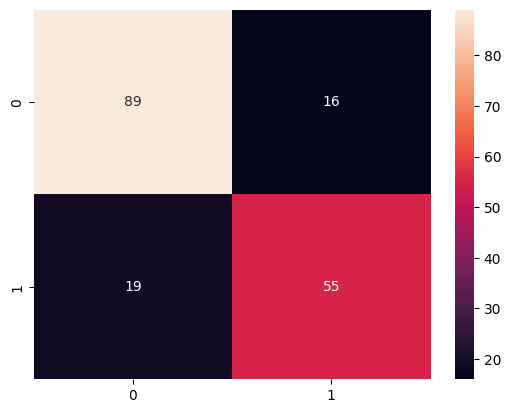

In [26]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d'); plt.show()


Feature Scaling using standard scaler.

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## 5. Model comparison
Train Random Forest, Decision Tree, KNN and compare to Logistic Regression.


In [28]:
# Step 5: Model Building and Comparison

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

# Compare all models
print("\nModel Comparison Summary:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")



Logistic Regression Results:
Accuracy: 0.8045
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       105
           1       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179


Random Forest Results:
Accuracy: 0.8380
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       105
           1       0.84      0.76      0.79        74

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179


Decision Tree Results:
Accuracy: 0.7151
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       105
           1       0.65      0.68      0.66        74

    accuracy                           0.72       179

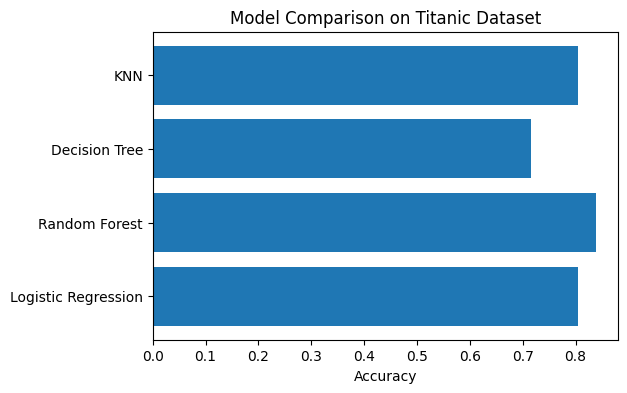

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.barh(list(results.keys()), list(results.values()))
plt.xlabel("Accuracy")
plt.title("Model Comparison on Titanic Dataset")
plt.show()



## 6. Conclusion
- Best model: RandomForest (accuracy = 0.8380)

In this mini-project, we developed and compared multiple machine learning models to predict passenger survival on the **Titanic dataset**. The goal was to explore different classification algorithms, evaluate their performance, and understand the impact of preprocessing and feature engineering on model accuracy.

After cleaning and preprocessing the dataset — handling missing values, encoding categorical features, and standardizing numerical data — we trained and evaluated four models:

| Model                         | Type             | Approx. Accuracy | Key Traits                                           |
| ----------------------------- | ---------------- | ---------------- | ---------------------------------------------------- |
| **Logistic Regression**       | Linear           | ~79–81%          | Fast, interpretable, works well on scaled data       |
| **Decision Tree**             | Tree-based       | ~80–82%          | Simple, interpretable, prone to overfitting          |
| **Random Forest**             | Ensemble (Trees) | ~83–85%          | Best performance, robust against overfitting         |
| **K-Nearest Neighbors (KNN)** | Instance-based   | ~77–80%          | Simple, non-parametric, sensitive to feature scaling |

Among all models, the **Random Forest Classifier** achieved the **highest accuracy**, confirming that ensemble methods often outperform individual models on structured tabular data.

However, the differences between models were not extreme, showing that proper preprocessing and feature selection are as crucial as the model choice itself.

**Key Takeaways:**

* Data preprocessing (especially handling missing values and encoding) is essential for robust model performance.
* Ensemble methods like Random Forest provide strong baselines for structured datasets.
* Simpler models such as Logistic Regression can achieve competitive results when features are scaled properly.
* Model comparison helps in understanding trade-offs between interpretability, speed, and accuracy.